In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import runtime
runtime.unassign()

In [2]:
!cp -r /content/drive/MyDrive/Data/1 /dev/shm/

In [ ]:
!cp -r /content/drive/MyDrive/Data/input_train /dev/shm/

# Initial Trials

In [2]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.0 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
from pathlib import Path
import torch
import timm
import timm.data
import timm.optim
import timm.scheduler
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, ConfusionMatrix
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
penalty_matrix = torch.tensor(
    [
        # Example for 3 classes. Adjust size/values for your classes.
        [0,    10000,    1,    1,    1,    1], # Defect 1
        [100,  0,      100,  100,  100,  100  ], # GOOD
        [1,    10000,    0,    1,    1,    1  ], # Defect 2
        [1,    10000,    1,    0,    1,    1  ], # Defect 3
        [1,    10000,    1,    1,    0,    1  ], # Defect 4
        [1,    10000,    1,    1,    1,    0  ], # Defect 5
    ],
    dtype=torch.float,
    device=device
)

## Data Loader

In [8]:
def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = ImageFolder(train_path, transform=train_transforms)

    val_dataset = ImageFolder(val_path, transform=eval_transforms)

    return train_dataset, val_dataset

## Utilities penalty functions

In [9]:
def penalty_loss(outputs, targets, penalty_matrix):
    """
    :param outputs: model logits of shape (B, C)
    :param targets: ground truth labels of shape (B,)
    :param penalty_matrix: (C x C) tensor where penalty_matrix[i, j]
                           is the penalty for predicting j when truth is i.
    :return: average penalty over the batch
    """
    # Convert logits to probabilities
    probs = F.softmax(outputs, dim=1)  # (B, C)

    # penalty_matrix[targets] selects the penalty row for each sample's true label
    # shape = (B, C)
    selected_penalties = penalty_matrix[targets]

    # Multiply each row by the corresponding probability distribution
    # and sum across classes to get the penalty for each sample
    sample_penalties = (selected_penalties * probs).sum(dim=1)  # (B,)

    # Return the average penalty over the batch
    return sample_penalties.mean()


In [10]:
import torch.nn.functional as F

def penalty_loss_log(outputs, targets, penalty_matrix):
    """
    Compute a penalty-weighted loss with logarithmic divergence for incorrect predictions.

    Args:
        outputs (Tensor): Model logits of shape (B, C)
        targets (Tensor): Ground truth labels of shape (B,)
        penalty_matrix (Tensor): A (C, C) tensor where penalty_matrix[i, j]
                                 is the penalty for predicting class j when the truth is i.
    Returns:
        Tensor: Average loss over the batch.
    """
    # Compute log-probabilities (B, C)
    log_probs = F.log_softmax(outputs, dim=1)

    # For each sample, select the penalty row corresponding to its true label (B, C)
    selected_penalties = penalty_matrix[targets]

    # Multiply the selected penalties with -log(probabilities)
    # This means that if p_j is small, -log(p_j) becomes large.
    sample_losses = (selected_penalties * (-log_probs)).sum(dim=1)

    # Average the loss over the batch
    return sample_losses.mean()


In [11]:
import torch
import torch.nn.functional as F

def softXEnt_with_penalty(inputs, target, labels, penalty_matrix):
    """
    Compute a "soft" cross-entropy loss weighted by a penalty matrix.

    Args:
        inputs (Tensor): Logits from the model with shape (B, C).
        target (Tensor): Soft target distributions with shape (B, C). These could be one-hot or smoothed distributions.
        labels (Tensor): Ground truth class indices of shape (B,).
        penalty_matrix (Tensor): A (C, C) tensor where penalty_matrix[i, j] is the penalty for predicting class j when the true class is i.

    Returns:
        Tensor: The average penalty-weighted soft cross-entropy loss.
    """
    # Compute log-probabilities
    logprobs = F.log_softmax(inputs, dim=1)  # shape (B, C)

    # For each sample, select the corresponding penalty row from the penalty matrix.
    # This yields a tensor of shape (B, C)
    penalties = penalty_matrix[labels]

    # Multiply the target distribution with the log probabilities and the penalties elementwise.
    # Then sum across classes and average over the batch.
    loss = - (target * logprobs * penalties).sum(dim=1).mean()
    return loss


In [12]:
def misclassB (pred, targ, D):   # pred[nBatch, nClass], targ[nBatch], D[nClass, nClass]
    pred = F.softmax(pred, dim=1)
    return  (D[targ] * (-(pred - 1.0).clamp (min = 1.e-7).log())).mean()

## Utility function for training

In [13]:
def print_metrics(epoch, train_loss, train_accuracy, val_loss, val_accuracy, penalty_per_image, cm, weighted_accuracy):
    """Prints the confusion matrix and training/validation metrics."""
    print("Confusion Matrix (rows = true, cols = predicted):")
    print(cm.cpu().numpy())
    print(f"Penalty per image: {penalty_per_image:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}  Train Acc: {train_accuracy:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}  Val   Acc: {val_accuracy:.4f}  Val Weighted Acc: {weighted_accuracy:.4f}")
    print("-----------------------------------------------------")

def compute_penalty(confusion_matrix, penalty_matrix):
    """Computes the penalty per image using the confusion matrix."""
    # Total number of samples
    total_samples = confusion_matrix.sum().item()

    # Maximum possible penalty in the penalty matrix (worst-case per sample)
    max_penalty = penalty_matrix.max()

    # Total penalty accumulated over all misclassified samples.
    # Since the diagonal of penalty_matrix should be 0 (no penalty on correct predictions),
    # we can simply multiply element-wise.
    total_penalty = (confusion_matrix * penalty_matrix).sum().item()

    # Normalize penalty by the worst-case penalty for all samples.
    normalized_penalty = total_penalty / (total_samples * max_penalty)

    # Compute Penalty-Weighted Accuracy (PWA)
    pwa = 1 - normalized_penalty
    #return float(pwa)
    return np.log(float(pwa)/(1 - float(pwa)))

In [14]:
def train_model_return_model(model, device, train_loader, val_loader, train_dataset, val_dataset,
                             optimizer, criterion, scheduler, num_epochs, num_classes,
                             penalty_matrix, class_weights, metrics=False):
    # -----------------------
    # Metrics initialization
    # -----------------------
    train_acc_history = []
    val_acc_history = []
    val_weighted_acc_history = []
    penalty_history = []


    train_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    val_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    val_confmat_metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

    # Training Loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_acc_metric.reset()

        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            #loss = penalty_loss(outputs, targets, penalty_matrix)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            train_acc_metric.update(preds, targets)

        train_loss /= len(train_dataset)
        train_accuracy = train_acc_metric.compute().item()
        train_acc_history.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_acc_metric.reset()
        val_confmat_metric.reset()

        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)

                preds = outputs.argmax(dim=1)
                val_acc_metric.update(preds, targets)
                val_confmat_metric.update(preds, targets)

        val_loss /= len(val_dataset)
        val_accuracy = val_acc_metric.compute().item()
        val_acc_history.append(val_accuracy)

        # Step scheduler
        scheduler.step(epoch)

        # Compute confusion matrix and penalty per image
        cm = val_confmat_metric.compute()
        penalty_per_image = compute_penalty(cm, penalty_matrix)
        penalty_history.append(penalty_per_image)

        # Assuming cm is a torch tensor
        true_positives = cm.diag()
        class_totals = cm.sum(dim=1)
        class_weights_tensor = torch.from_numpy(class_weights).to(device=cm.device)
        weighted_accuracy = (class_weights_tensor * true_positives).sum() / (class_weights_tensor * class_totals).sum()
        val_weighted_acc_history.append(weighted_accuracy.item())

        # Print metrics for current epoch
        print_metrics(epoch, train_loss, train_accuracy, val_loss, val_accuracy, penalty_per_image, cm, weighted_accuracy)


    # Optionally, save the model after training
    torch.save(model.state_dict(), "resnet50_trained.pth")

    # Plotting the metrics
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_history, 'b-', label="Train Accuracy")
    plt.plot(epochs, val_acc_history, 'r-', label="Val Accuracy")
    plt.plot(epochs, val_weighted_acc_history, 'g-', label="Val Weighted Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation Accuracy")
    plt.legend()

    # Plot penalty per image
    plt.subplot(1, 2, 2)
    plt.plot(epochs, penalty_history, 'g-', label="Penalty per Image")
    plt.xlabel("Epoch")
    plt.ylabel("Penalty per Image")
    plt.title("Penalty per Image per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return only the trained model
    if metrics==True:
      return val_weighted_acc_history, penalty_history
    else:
      return model

## Training

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Samples per class: [  55  986  215   82 5177   99]
Class weights: [0.01818182 0.0010142  0.00465116 0.01219512 0.00019316 0.01010101]
Confusion Matrix (rows = true, cols = predicted):
[[ 13   3   0   0   0   0]
 [  9 232   0   0   0   8]
 [ 23  32   0   0   0   0]
 [  0  22   0   0   0   0]
 [  0 657   0   0 636   2]
 [  0   7   0   0   0  20]]
Penalty per image: 0.2680
Epoch 1/20:
  Train Loss: 1.6696  Train Acc: 0.2688
  Val   Loss: 1.3432  Val   Acc: 0.5415  Val Weighted Acc: 0.5008
-----------------------------------------------------
Confusion Matrix (rows = true, cols = predicted):
[[ 13   0   1   2   0   0]
 [ 13 133   0  97   0   6]
 [ 22   0   1  32   0   0]
 [  0   2   0  20   0   0]
 [  0   0   0 656 637   2]
 [  0   0   0   7   0  20]]
Penalty per image: 6.2419
Epoch 2/20:
  Train Loss: 1.4746  Train Acc: 0.3923
  Val   Loss: 0.9333  Val   Acc: 0.4952  Val Weighted Acc: 0.5941
-----------------------------------------------------
Confusion Matrix (rows = true, cols = predic

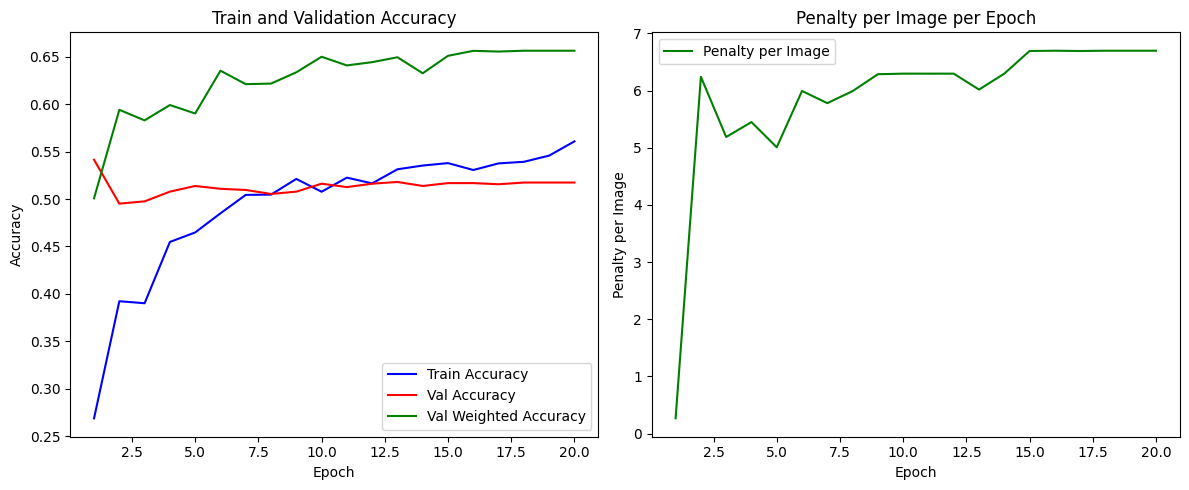

In [15]:
# -----------------------
# Configuration
# -----------------------
data_path = "/dev/shm/1"
data_path = Path(data_path)
train_dir = data_path / "train"
val_dir = data_path / "val"
num_classes = len(list(train_dir.iterdir()))
image_size = (224, 224)
batch_size = 32
num_epochs = 20
lr = 1e-3

# Define device for GPU usage.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Model, Data Transforms and Datasets
# -----------------------
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]
train_dataset, val_dataset = create_datasets(
    train_path=train_dir,
    val_path=val_dir,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
print("Samples per class:", class_counts)
class_weights = 1. / class_counts
print("Class weights:", class_weights)

# Assign a weight to each sample in the dataset.
sample_weights = np.array([class_weights[t] for t in targets])
sample_weights = torch.from_numpy(sample_weights).float()
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# -----------------------
# Model, Loss, Optimizer and Scheduler
# -----------------------
# Loss function (CrossEntropy for multi-class classification)
weights = torch.tensor([1.0, 1.5, 1.0, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss()

# Create optimizer using timm's optimizer creation helper
optimizer = timm.optim.create_optimizer_v2(model, opt="adamw", lr=lr, weight_decay=1e-4)

# Create a cosine annealing learning rate scheduler from timm.scheduler
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_lr_init=1e-4,
    warmup_t=1,
    t_in_epochs=True
)

trained_model = train_model_return_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=num_epochs,
    num_classes=num_classes,
    penalty_matrix=penalty_matrix,
    class_weights=class_weights
)

In [ ]:
# -----------------------
# Configuration
# -----------------------
data_path = "/dev/shm/2"
data_path = Path(data_path)
train_dir = data_path / "train"
val_dir = data_path / "val"
num_classes = len(list(train_dir.iterdir()))
image_size = (224, 224)
batch_size = 32
num_epochs = 20
lr = 1e-3

# Define device for GPU usage.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Model, Data Transforms and Datasets
# -----------------------
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]
train_dataset, val_dataset = create_datasets(
    train_path=train_dir,
    val_path=val_dir,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
print("Samples per class:", class_counts)
class_weights = 1. / class_counts
print("Class weights:", class_weights)

# Assign a weight to each sample in the dataset.
sample_weights = np.array([class_weights[t] for t in targets])
sample_weights = torch.from_numpy(sample_weights).float()
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# -----------------------
# Model, Loss, Optimizer and Scheduler
# -----------------------
# Loss function (CrossEntropy for multi-class classification)
val_weighted_acc_history, penalty_history = [], []
for i in np.linspace(1.1, 1.5, 5):
  model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
  model = model.to(device)

  weights = torch.tensor([1.0, float(i), 1.0, 1.0, 1.0, 1.0]).to(device)
  criterion = nn.CrossEntropyLoss(weight=weights)
  #criterion = nn.CrossEntropyLoss()

  # Create optimizer using timm's optimizer creation helper
  optimizer = timm.optim.create_optimizer_v2(model, opt="adamw", lr=lr, weight_decay=1e-4)

  # Create a cosine annealing learning rate scheduler from timm.scheduler
  scheduler = timm.scheduler.CosineLRScheduler(
      optimizer,
      t_initial=num_epochs,
      lr_min=1e-6,
      warmup_lr_init=1e-4,
      warmup_t=1,
      t_in_epochs=True
  )

  val_weighted_acc, penalty = train_model_return_model(
      model=model,
      device=device,
      train_loader=train_loader,
      val_loader=val_loader,
      train_dataset=train_dataset,
      val_dataset=val_dataset,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      num_epochs=num_epochs,
      num_classes=num_classes,
      penalty_matrix=penalty_matrix,
      class_weights=class_weights,
      metrics=True
  )
  val_weighted_acc_history.append(val_weighted_acc)
  penalty_history.append(penalty)

In [ ]:
epochs = range(num_epochs)

# List of parameter values (adjust this according to your actual parameter range)
parameter_values = np.linspace(0.01, 1, len(val_weighted_acc_history))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot each line in val_weighted_acc_history (on the first subplot)
for i, val_acc in enumerate(val_weighted_acc_history):
    ax1.plot(epochs, val_acc, label=f'Param {parameter_values[i]:.2f} - Val Accuracy', linestyle='-', marker='o')

# Set axis labels for the first subplot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Weighted Accuracy')
ax1.set_title('Validation Accuracy for Different Parameters')

# Add legend to the first subplot
ax1.legend(title='Validation Accuracy')

# Plot each line in penalty_history (on the second subplot)
for i, penalty in enumerate(penalty_history):
    ax2.plot(epochs, penalty, label=f'Param {parameter_values[i]:.2f} - Penalty', linestyle='--', marker='x')

# Set axis labels for the second subplot
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Penalty')
ax2.set_title('Penalty for Different Parameters')

# Add legend to the second subplot
ax2.legend(title='Penalty')

# Adjust layout to avoid overlap
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
epochs = range(num_epochs)

# List of parameter values (adjust this according to your actual parameter range)
parameter_values = np.linspace(1.1, 1.5, 5)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot each line in val_weighted_acc_history (on the first subplot)
for i, val_acc in enumerate(val_weighted_acc_history):
    ax1.plot(epochs, val_acc, label=f'Param {parameter_values[i]:.2f} - Val Accuracy', linestyle='-', marker='o')

# Set axis labels for the first subplot
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Weighted Accuracy')
ax1.set_title('Validation Accuracy for Different Parameters')

# Add legend to the first subplot
ax1.legend(title='Validation Accuracy')

# Plot each line in penalty_history (on the second subplot)
for i, penalty in enumerate(penalty_history):
    ax2.plot(epochs, penalty, label=f'Param {parameter_values[i]:.2f} - Penalty', linestyle='--', marker='x')

# Set axis labels for the second subplot
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Penalty')
ax2.set_title('Penalty for Different Parameters')

# Add legend to the second subplot
ax2.legend(title='Penalty')

# Adjust layout to avoid overlap
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# -----------------------
# Configuration
# -----------------------
import copy

model = copy.deepcopy(trained_model)
num_classes = len(list(train_dir.iterdir()))
num_epochs = 3
lr = 1e-4

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Now only the parameters of model.fc are trainable by default.
for param in model.fc.parameters():
    param.requires_grad = True

# -----------------------
# Model, Loss, Optimizer and Scheduler
# -----------------------
# Loss function (CrossEntropy for multi-class classification)
criterion = lambda x, z: penalty_loss(x, z, penalty_matrix)

# Set up your optimizer to update only the trainable parameters.
optimizer = timm.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  # Only trainable params
    lr=lr,
    weight_decay=1e-2  # Adjust as needed
)

# Create a cosine annealing learning rate scheduler from timm.scheduler
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_lr_init=1e-5,
    warmup_t=1,
    t_in_epochs=True
)

trained_model_2 = train_model_return_model(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=num_epochs,
    num_classes=num_classes,
    penalty_matrix=penalty_matrix,
    class_weights=class_weights
)

In [15]:

class CustomModel(nn.Module):
    def __init__(self, model, num_classes, special_class=1, threshold=0.7):
        super(CustomModel, self).__init__()
        self.model = trained_model  # Pre-trained ResNet model
        self.num_classes = num_classes
        self.special_class = special_class  # Class you want to threshold
        self.threshold = threshold

        # Freeze all layers so no weights are modified during training
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        logits = self.model(x)  # Get raw outputs
        return logits  # Standard output without modification during training

    def predict(self, x):
        """Use this method for inference with custom thresholding."""
        logits = self.model(x)  # Get raw outputs
        probs = F.softmax(logits, dim=1)  # Convert to probabilities
        preds = torch.argmax(probs, dim=1)  # Default prediction

        # Apply custom threshold for the special class
        special_class_mask = (preds == self.special_class) & (probs[:, self.special_class] < self.threshold)

        # Instead of rejecting, choose the next most probable class
        next_most_probable_class = torch.topk(probs, 2, dim=1).indices[:, 1]  # Get the second most probable class
        preds[special_class_mask] = next_most_probable_class[special_class_mask]

        return preds, probs

In [ ]:
# -----------------------
# Configuration
# -----------------------
import copy

model = copy.deepcopy(trained_model)
num_classes = len(list(train_dir.iterdir()))
num_epochs = 5
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming CustomModel is defined as earlier
model = CustomModel(model=model, num_classes=num_classes, threshold=0.6).to(device)

val_acc_history = []
val_weighted_acc_history = []
penalty_history = []

val_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
val_confmat_metric = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

# Validation phase
model.eval()
val_loss = 0.0
val_acc_metric.reset()
val_confmat_metric.reset()

with torch.no_grad():
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)

        # Forward pass
        outputs = model(images)  # This returns raw logits

        # Calculate loss
        loss = criterion(outputs, targets)
        val_loss += loss.item() * images.size(0)

        # Get predictions with custom thresholding
        preds, probs = model.predict(images)  # Use custom predict method with threshold

        # Update metrics
        val_acc_metric.update(preds, targets)
        val_confmat_metric.update(preds, targets)

# Average loss for validation set
val_loss /= len(val_dataset)

# Compute accuracy
val_accuracy = val_acc_metric.compute().item()
val_acc_history.append(val_accuracy)

# Compute confusion matrix and penalty per image
cm = val_confmat_metric.compute()
penalty_per_image = compute_penalty(cm, penalty_matrix)
penalty_history.append(penalty_per_image)

# Weighted accuracy
true_positives = cm.diag()
class_totals = cm.sum(dim=1)
class_weights_tensor = torch.from_numpy(class_weights).to(device=cm.device)
weighted_accuracy = (class_weights_tensor * true_positives).sum() / (class_weights_tensor * class_totals).sum()
val_weighted_acc_history.append(weighted_accuracy.item())

# Print metrics for the current epoch (here epoch is 0 since it's a validation phase)
print_metrics(0, 0.0, 0.0, val_loss, val_accuracy, penalty_per_image, cm, weighted_accuracy)


# Train without val

In [30]:
def create_datasets_train(image_size, data_mean, data_std, train_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    train_dataset = ImageFolder(train_path, transform=train_transforms)

    return train_dataset

In [31]:
def train_model_return_model_train(model, device, train_loader, train_dataset,
                             optimizer, criterion, scheduler, num_epochs, num_classes,
                             penalty_matrix, class_weights, metrics=False):
    # -----------------------
    # Metrics initialization
    # -----------------------
    train_acc_history = []

    train_acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)


    # Training Loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_acc_metric.reset()

        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            #loss = penalty_loss(outputs, targets, penalty_matrix)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            train_acc_metric.update(preds, targets)

        train_loss /= len(train_dataset)
        train_accuracy = train_acc_metric.compute().item()
        train_acc_history.append(train_accuracy)

        # Step scheduler
        scheduler.step(epoch)

        # Print metrics for current epoch
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}  Train Acc: {train_accuracy:.4f}")


    # Optionally, save the model after training
    torch.save(model.state_dict(), "/content/drive/MyDrive/Data/6/resnet50_trained.pth")

    # Plotting the metrics
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_history, 'b-', label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return only the trained model
    if metrics==True:
      return val_weighted_acc_history, penalty_history
    else:
      return model

6
/dev/shm/6/train
/dev/shm/6/train
Samples per class: [  71 1235  270  104 6472  126]
Class weights: [0.01408451 0.00080972 0.0037037  0.00961538 0.00015451 0.00793651]
Epoch 1/20:
  Train Loss: 1.6522  Train Acc: 0.2674
Epoch 2/20:
  Train Loss: 1.4605  Train Acc: 0.3972
Epoch 3/20:
  Train Loss: 1.4179  Train Acc: 0.4123
Epoch 4/20:
  Train Loss: 1.3194  Train Acc: 0.4478
Epoch 5/20:
  Train Loss: 1.2680  Train Acc: 0.4643
Epoch 6/20:
  Train Loss: 1.2288  Train Acc: 0.4884
Epoch 7/20:
  Train Loss: 1.2262  Train Acc: 0.4960
Epoch 8/20:
  Train Loss: 1.2220  Train Acc: 0.4856
Epoch 9/20:
  Train Loss: 1.1732  Train Acc: 0.5081
Epoch 10/20:
  Train Loss: 1.1664  Train Acc: 0.5115
Epoch 11/20:
  Train Loss: 1.1500  Train Acc: 0.5227
Epoch 12/20:
  Train Loss: 1.1356  Train Acc: 0.5219
Epoch 13/20:
  Train Loss: 1.1463  Train Acc: 0.5237
Epoch 14/20:
  Train Loss: 1.1397  Train Acc: 0.5273
Epoch 15/20:
  Train Loss: 1.1401  Train Acc: 0.5212
Epoch 16/20:
  Train Loss: 1.1073  Train Acc

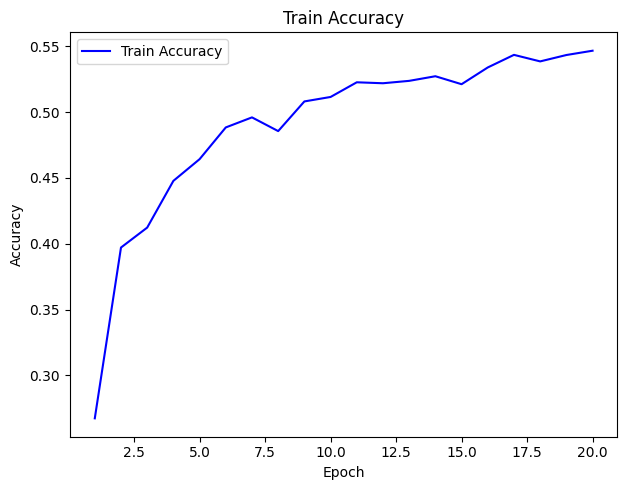

In [ ]:
# -----------------------
# Configuration
# -----------------------
data_path = "/dev/shm/6"
data_path = Path(data_path)
train_dir = data_path / "train"
num_classes = len(list(train_dir.iterdir()))
image_size = (224, 224)
batch_size = 32
num_epochs = 20
lr = 1e-3

# Define device for GPU usage.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Model, Data Transforms and Datasets
# -----------------------
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model = model.to(device)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

train_dataset = create_datasets_train(
    train_path=train_dir,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
print("Samples per class:", class_counts)
class_weights = 1. / class_counts
print("Class weights:", class_weights)

# Assign a weight to each sample in the dataset.
sample_weights = np.array([class_weights[t] for t in targets])
sample_weights = torch.from_numpy(sample_weights).float()
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, sampler=sampler)

# -----------------------
# Model, Loss, Optimizer and Scheduler
# -----------------------
# Loss function (CrossEntropy for multi-class classification)
weights = torch.tensor([1.0, 1.5, 1.0, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss()

# Create optimizer using timm's optimizer creation helper
optimizer = timm.optim.create_optimizer_v2(model, opt="adamw", lr=lr, weight_decay=1e-4)

# Create a cosine annealing learning rate scheduler from timm.scheduler
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_lr_init=1e-4,
    warmup_t=1,
    t_in_epochs=True
)

trained_model = train_model_return_model_train(
    model=model,
    device=device,
    train_loader=train_loader,
    train_dataset=train_dataset,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=num_epochs,
    num_classes=num_classes,
    penalty_matrix=penalty_matrix,
    class_weights=class_weights
)

# Inference

In [22]:

class CustomModel(nn.Module):
    def __init__(self, model, num_classes, special_class=1, threshold=0.7):
        super(CustomModel, self).__init__()
        self.model = model  # Pre-trained ResNet model
        self.num_classes = num_classes
        self.special_class = special_class  # Class you want to threshold
        self.threshold = threshold

        # Freeze all layers so no weights are modified during training
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        logits = self.model(x)  # Get raw outputs
        return logits  # Standard output without modification during training

    def predict(self, x):
        """Use this method for inference with custom thresholding."""
        logits = self.model(x)  # Get raw outputs
        probs = F.softmax(logits, dim=1)  # Convert to probabilities
        preds = torch.argmax(probs, dim=1)  # Default prediction

        # Apply custom threshold for the special class
        special_class_mask = (preds == self.special_class) & (probs[:, self.special_class] < self.threshold)

        # Instead of rejecting, choose the next most probable class
        next_most_probable_class = torch.topk(probs, 2, dim=1).indices[:, 1]  # Get the second most probable class
        preds[special_class_mask] = next_most_probable_class[special_class_mask]

        return preds, probs

In [17]:
import os
from pathlib import Path
import torch
import pandas as pd
import timm
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import timm.data

class UnlabeledImageDataset(Dataset):
    """
    Custom Dataset to load images from a single folder where images have no category subfolders.
    """
    def __init__(self, folder_path, transform):
        self.folder_path = Path(folder_path)
        self.image_files = [f for f in self.folder_path.iterdir() if f.suffix.lower() in (".jpg", ".jpeg", ".png", ".bmp", ".tiff")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, image_path.name  # Return filename instead of label

In [18]:
def create_datasets_test(image_size, data_mean, data_std, test_path):
    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    test_dataset = UnlabeledImageDataset(test_path, transform=eval_transforms)
    return test_dataset

In [19]:
def inference_to_dataframe(model, data_loader, device):
    """
    Perform inference using the given model and data loader, and return a DataFrame
    with filenames and predicted labels.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader that yields (images, filenames) for each batch.
        device: Torch device ('cpu' or 'cuda').

    Returns:
        pd.DataFrame: A DataFrame with two columns: 'filename' and 'label'.
    """
    model.eval()  # Set model to evaluation mode
    results = []

    with torch.no_grad():
        for images, filenames in data_loader:
            images = images.to(device)

            # Get model predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class index

            # Store results
            for fname, pred in zip(filenames, preds):
                results.append({"filename": fname, "label": pred.item()})

    return pd.DataFrame(results)

In [20]:
!cp -r /content/drive/MyDrive/Data/input_test /dev/shm/

In [25]:
!cp -r /content/drive/MyDrive/Data/6 /dev/shm/

In [24]:
# -----------------------
# Configuration
# -----------------------
data_path = "/dev/shm/input_test"
data_path = Path(data_path)
test_dir = data_path
num_classes = 6
image_size = (224, 224)
batch_size = 32

# Define device for GPU usage.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Model, Data Transforms and Datasets
# -----------------------
model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/Data/6/resnet50_trained.pth", map_location=device))
model = CustomModel(model=model, num_classes=num_classes, threshold=0.8)
model = model.to(device)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

# Create dataset and dataloader
test_dataset = create_datasets_test(
    test_path=test_dir,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Perform inference
df_results = inference_to_dataframe(model, test_loader, device)

# Display results
print(df_results)

                                               filename  label
0     10b0c36579c608d2e75e2d660846009fca886b92c674ba...      4
1     8e7bee7f365ba606a9c9a54f964888f1d265b3f0c50822...      2
2     9fe847a508bdff0d38e792564851c104f9fe0a43857b39...      1
3     dbcfd65a5faabb5dc341a6c86978432a743f90bca68fae...      2
4     7f212d97555a629d6a907a2a15c8ce52a06fe285e667eb...      5
...                                                 ...    ...
1050  687d28950337f8d5d45f336e43a2bc81a4b054ae47f4e8...      5
1051  2a4290dd5f2b026de9ec0ef37faf2029c4357d99fd6dd3...      2
1052  fb9c4ed679249e950f25671686af022be971bc6c607de7...      2
1053  ba624f93ea0e7575c973d699872d22d56c4a3da2294e58...      0
1054  feedf3c223c1ef98db420cdf63dd15af9c264664dc69c9...      2

[1055 rows x 2 columns]


In [26]:
df_results.to_csv("/content/drive/MyDrive/Data/6/0.8_results.csv", index=False)

In [32]:
# -----------------------
# Configuration
# -----------------------

data_path = "/dev/shm/"
data_path = Path(data_path)
train_dir = data_path / "input_train"
num_classes = 6
image_size = (224, 224)
batch_size = 32
num_epochs = 3
lr = 1e-4


model = timm.create_model("resnet50", pretrained=True, num_classes=num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/Data/6/resnet50_trained.pth", map_location=device))
model = model.to(device)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Now only the parameters of model.fc are trainable by default.
for param in model.fc.parameters():
    param.requires_grad = True



# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

train_dataset = create_datasets_train(
    train_path=train_dir,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

targets = [s[1] for s in train_dataset.samples]
class_counts = np.bincount(targets)
print("Samples per class:", class_counts)
class_weights = 1. / class_counts
print("Class weights:", class_weights)

# Assign a weight to each sample in the dataset.
sample_weights = np.array([class_weights[t] for t in targets])
sample_weights = torch.from_numpy(sample_weights).float()
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders.
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, sampler=sampler)




# -----------------------
# Model, Loss, Optimizer and Scheduler
# -----------------------
# Loss function (CrossEntropy for multi-class classification)
criterion = lambda x, z: penalty_loss(x, z, penalty_matrix)

# Set up your optimizer to update only the trainable parameters.
optimizer = timm.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  # Only trainable params
    lr=lr,
    weight_decay=1e-2  # Adjust as needed
)

# Create a cosine annealing learning rate scheduler from timm.scheduler
scheduler = timm.scheduler.CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_lr_init=1e-5,
    warmup_t=1,
    t_in_epochs=True
)

trained_model = train_model_return_model_train(
    model=model,
    device=device,
    train_loader=train_loader,
    train_dataset=train_dataset,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=num_epochs,
    num_classes=num_classes,
    penalty_matrix=penalty_matrix,
    class_weights=class_weights
)

FileNotFoundError: Couldn't find any class folder in /dev/shm/input_train.

In [ ]:
# -----------------------
# Configuration
# -----------------------
data_path = "/dev/shm/input_test"
data_path = Path(data_path)
test_dir = data_path
num_classes = 6
image_size = (224, 224)
batch_size = 32

# Define device for GPU usage.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Model, Data Transforms and Datasets
# -----------------------
model = trained_model

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

# Create dataset and dataloader
test_dataset = create_datasets_test(
    test_path=test_dir,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Perform inference
df_results = inference_to_dataframe(model, test_loader, device)

# Display results
print(df_results)

# Big Boy

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
!pip install pytorch-accelerated

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.5.2
    Uninstalling accelerate-1.5.2:
      Successfully uninstalled accelerate-1.5.2


In [ ]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
import torchmetrics
from timm.scheduler import CosineLRScheduler

from pytorch_accelerated.callbacks import SaveBestModelCallback
from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

INFO:pytorch_accelerated:Setting random seeds


In [ ]:
def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        #auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = timm.data.dataset.ImageDataset(
        train_path, transform=train_transforms
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms)

    return train_dataset, eval_dataset

In [ ]:
class TimmMixupTrainer(Trainer):
    def __init__(self, eval_loss_fn, mixup_args, num_classes, penalty_matrix, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.eval_loss_fn = eval_loss_fn
        self.num_updates = None
        self.mixup_fn = timm.data.Mixup(**mixup_args)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.ema_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.ema_model = None

        self.penalty_matrix = torch.tensor(penalty_matrix, dtype=torch.float)

        self.all_preds = []
        self.all_targets = []

    def create_scheduler(self):
        return timm.scheduler.CosineLRScheduler(
            self.optimizer,
            t_initial=self.run_config.num_epochs,
            cycle_decay=0.5,
            lr_min=1e-6,
            t_in_epochs=True,
            warmup_t=3,
            warmup_lr_init=1e-4,
            cycle_limit=1,
        )

    def training_run_start(self):
        # Model EMA requires the model without a DDP wrapper and before sync batchnorm conversion
        self.ema_model = timm.utils.ModelEmaV2(
            self._accelerator.unwrap_model(self.model), decay=0.9
        )
        if self.run_config.is_distributed:
            self.model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(self.model)

    def train_epoch_start(self):
        super().train_epoch_start()
        self.num_updates = self.run_history.current_epoch * len(self._train_dataloader)

    def calculate_train_batch_loss(self, batch):
        xb, yb = batch
        mixup_xb, mixup_yb = self.mixup_fn(xb, yb)
        return super().calculate_train_batch_loss((mixup_xb, mixup_yb))

    def train_epoch_end(
        self,
    ):
        self.ema_model.update(self.model)
        self.ema_model.eval()

        if hasattr(self.optimizer, "sync_lookahead"):
            self.optimizer.sync_lookahead()

    def scheduler_step(self):
        self.num_updates += 1
        if self.scheduler is not None:
            self.scheduler.step_update(num_updates=self.num_updates)

    def calculate_eval_batch_loss(self, batch):
        with torch.no_grad():
            xb, yb = batch
            outputs = self.model(xb)
            val_loss = self.eval_loss_fn(outputs, yb)
            preds = outputs.argmax(dim=-1)

            self.accuracy.update(preds, yb)
            ema_model_preds = self.ema_model.module(xb).argmax(dim=-1)
            self.ema_accuracy.update(ema_model_preds, yb)

            self.all_preds.append(preds.cpu())
            self.all_targets.append(yb.cpu())

        return {"loss": val_loss, "model_outputs": outputs, "batch_size": xb.size(0)}

    def compute_total_penalty(self):
        # Concatenate all stored predictions and targets
        all_preds = torch.cat(self.all_preds)
        all_targets = torch.cat(self.all_targets)
        num_classes = self.penalty_matrix.shape[0]

        # Initialize confusion matrix
        conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.float)

        # Build the confusion matrix: for each true (i) and predicted (j)
        for t, p in zip(all_targets, all_preds):
            conf_matrix[t.long(), p.long()] += 1

        print(conf_matrix)
        # Multiply element-wise with the penalty matrix and sum the result
        total_penalty = torch.sum(conf_matrix * self.penalty_matrix)
        return total_penalty


    def eval_epoch_end(self):
        super().eval_epoch_end()

        if self.scheduler is not None:
            self.scheduler.step(self.run_history.current_epoch + 1)

        self.run_history.update_metric("accuracy", self.accuracy.compute().cpu())
        self.run_history.update_metric(
            "ema_model_accuracy", self.ema_accuracy.compute().cpu()
        )

        total_penalty = self.compute_total_penalty()
        self.run_history.update_metric("total_penalty", total_penalty.cpu())

        self.accuracy.reset()
        self.ema_accuracy.reset()
        self.all_preds = []
        self.all_targets = []

In [ ]:
import numpy as np

penalty_matrix = np.array([
    [0,    10000,    1,    1,    1,    1],
    [100,  0,      100,  100,  100,  100  ],
    [1,    10000,    0,    1,    1,    1  ],
    [1,    10000,    1,    0,    1,    1  ],
    [1,    10000,    1,    1,    0,    1  ],
    [1,    10000,    1,    1,    1,    0  ],
])


In [ ]:
data_path = "/content/drive/MyDrive/Data/2"
# Set training arguments, hardcoded here for clarity
image_size = (224, 224)
lr = 5e-4
smoothing = 0.1
mixup = 0.2
cutmix = 1.0
batch_size = 32
bce_target_thresh = 0.2
num_epochs = 5

data_path = Path(data_path)
train_path = data_path / "train"
val_path = data_path / "val"
num_classes = len(list(train_path.iterdir()))

mixup_args = dict(
    mixup_alpha=mixup,
    cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=num_classes,
)

# Create model using timm
model = timm.create_model(
    "resnet50d", pretrained=False, num_classes=num_classes, drop_path_rate=0.05
)

# Load data config associated with the model to use in data augmentation pipeline
data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
data_mean = data_config["mean"]
data_std = data_config["std"]

# Create training and validation datasets
train_dataset, eval_dataset = create_datasets(
    train_path=train_path,
    val_path=val_path,
    image_size=image_size,
    data_mean=data_mean,
    data_std=data_std,
)

# Create optimizer
optimizer = timm.optim.create_optimizer_v2(
    model, opt="lookahead_AdamW", lr=lr, weight_decay=0.01
)

# As we are using Mixup, we can use BCE during training and CE for evaluation
train_loss_fn = timm.loss.BinaryCrossEntropy(
    target_threshold=bce_target_thresh, smoothing=smoothing
)
validate_loss_fn = torch.nn.CrossEntropyLoss()

# Create trainer and start training
trainer = TimmMixupTrainer(
    model=model,
    optimizer=optimizer,
    loss_func=train_loss_fn,
    eval_loss_fn=validate_loss_fn,
    mixup_args=mixup_args,
    num_classes=num_classes,
    penalty_matrix=penalty_matrix,  # pass your defined penalty matrix here
    callbacks=[
        *DEFAULT_CALLBACKS,
        SaveBestModelCallback(watch_metric="accuracy", greater_is_better=True),
    ],
)

trainer.train(
    per_device_batch_size=batch_size,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    num_epochs=num_epochs,
    create_scheduler_fn=trainer.create_scheduler,
)


Starting training run

Starting epoch 1



 92%|█████████▏| 12/13 [00:04<00:00,  3.05it/s]

AssertionError: Batch size should be even when using this

# Data Preparation

In [ ]:
import os

# Define the data directory and file paths
data_dir = "/content/drive/MyDrive/Data/"
input_train_dir = os.path.join(data_dir, "input_train")
split_folder = os.path.join(data_dir, "1")

LIMIT_MISSING_TRAINING = False
MAX_MISSING_TRAINING = 3000

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to the original CSV file with all image metadata.
csv_path = "/content/drive/MyDrive/Data/Y_train_eVW9jym.csv"

# Read the CSV file.
df = pd.read_csv(csv_path)

# Lists to hold the splits
train_list = []
test_list = []

# Perform a stratified split for each combination of Label and lib.
# This ensures that every (Label, lib) group is represented in both splits.
for (label, lib), group in df.groupby(["Label", "lib"]):
    # If a group has only one sample, assign it to training (or you can decide otherwise)
    if len(group) < 2:
        train_list.append(group)
    else:
        train_group, test_group = train_test_split(group, test_size=0.2, random_state=42)
        train_list.append(train_group)
        test_list.append(test_group)

# Concatenate the groups back together.
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)


if LIMIT_MISSING_TRAINING:
    missing_df = train_df[train_df["Label"] == "Missing"]
    other_df = train_df[train_df["Label"] != "Missing"]

    if len(missing_df) > MAX_MISSING_TRAINING:
        total_missing = len(missing_df)
        sampled_groups = []

        # For each subgroup in missing data (grouped by 'lib'), sample proportionally.
        for lib, group in missing_df.groupby("lib"):
            # Compute the number of samples to draw from this group.
            n_samples = round(len(group) / total_missing * MAX_MISSING_TRAINING)
            # Ensure that each non-empty group gets at least one sample.
            n_samples = max(n_samples, 1)
            sampled_groups.append(group.sample(n=n_samples, random_state=42))

        missing_df = pd.concat(sampled_groups)

    # Recombine the training data.
    train_df = pd.concat([other_df, missing_df]).reset_index(drop=True)


# Create a folder to store the new CSV splits.
os.makedirs(split_folder, exist_ok=True)

# Write the CSV files.
train_csv_path = os.path.join(split_folder, "train.csv")
test_csv_path = os.path.join(split_folder, "test.csv")
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("Train and test CSV files have been saved in:", split_folder)


In [ ]:
import os

# Define the data directory and file paths
data_dir = "/content/drive/MyDrive/Data/"
input_train_dir = os.path.join(data_dir, "input_train")
split_folder = os.path.join(data_dir, "5")

LIMIT_MISSING_TRAINING = False
MAX_MISSING_TRAINING = 3000
MAX_TRAIN_IMAGES = 130
MAX_TEST_IMAGES = 300

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Path to the original CSV file with all image metadata.
csv_path = "/content/drive/MyDrive/Data/Y_train_eVW9jym.csv"

# Read the CSV file.
df = pd.read_csv(csv_path)

# Lists to hold the splits
train_list = []
test_list = []

# Perform a stratified split for each combination of Label and lib.
# This ensures that every (Label, lib) group is represented in both splits.
for (label, lib), group in df.groupby(["Label", "lib"]):
    # If a group has only one sample, assign it to training (or you can decide otherwise)
    if len(group) < 2:
        train_list.append(group)
    else:
        train_group, test_group = train_test_split(group, test_size=0.2, random_state=42)
        train_list.append(train_group)
        test_list.append(test_group)

# Concatenate the groups back together.
train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

if LIMIT_MISSING_TRAINING:
    missing_df = train_df[train_df["Label"] == "Missing"]
    other_df = train_df[train_df["Label"] != "Missing"]

    if len(missing_df) > MAX_MISSING_TRAINING:
        total_missing = len(missing_df)
        sampled_groups = []

        # For each subgroup in missing data (grouped by 'lib'), sample proportionally.
        for lib, group in missing_df.groupby("lib"):
            # Compute the number of samples to draw from this group.
            n_samples = round(len(group) / total_missing * MAX_MISSING_TRAINING)
            # Ensure that each non-empty group gets at least one sample.
            n_samples = max(n_samples, 1)
            sampled_groups.append(group.sample(n=n_samples, random_state=42))

        missing_df = pd.concat(sampled_groups)

    # Recombine the training data.
    train_df = pd.concat([other_df, missing_df]).reset_index(drop=True)


# Helper function to perform stratified sampling on a DataFrame
def stratified_sample(df, max_samples, group_cols=["Label", "lib"]):
    total = len(df)
    groups = []
    # Group by the desired columns and sample from each group proportionally.
    for name, group in df.groupby(group_cols):
        # Determine the number of samples for this group based on its proportion.
        n_samples = round(len(group) / total * max_samples)
        # Ensure at least one sample per group if the group exists.
        n_samples = max(min(n_samples, len(group)), 1)
        groups.append(group.sample(n=n_samples, random_state=42))
    return pd.concat(groups).reset_index(drop=True)


# Limit the number of images in the train and test sets using stratified sampling.
train_df = stratified_sample(train_df, MAX_TRAIN_IMAGES, group_cols=["Label", "lib"])
test_df = stratified_sample(test_df, MAX_TEST_IMAGES, group_cols=["Label", "lib"])

# Create a folder to store the new CSV splits.
os.makedirs(split_folder, exist_ok=True)

# Write the CSV files.
train_csv_path = os.path.join(split_folder, "train.csv")
test_csv_path = os.path.join(split_folder, "test.csv")
train_df.to_csv(train_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

print("Train and test CSV files have been saved in:", split_folder)

Train and test CSV files have been saved in: /content/drive/MyDrive/Data/5


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Data/5/train.csv')

# Find the maximum number of samples in any label
max_count = df['Label'].value_counts().max()

# Create an empty list to collect balanced dataframes
balanced_dfs = []

# Loop over each label group
for label, group in df.groupby('Label'):
    # Upsample the group if needed (sample with replacement)
    group_upsampled = group.sample(max_count, replace=True, random_state=42)
    balanced_dfs.append(group_upsampled)

# Concatenate all the upsampled groups
balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)

# Optionally, save the balanced dataset to a new CSV file
balanced_df.to_csv('/content/drive/MyDrive/Data/5/train_balanced.csv', index=False)

print("Balanced dataset saved as train_balanced.csv")

Balanced dataset saved as train_balanced.csv


With Categories

In [ ]:
import os
import pandas as pd
import shutil

def copy_images_by_class(csv_path, output_dir, source_dir):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Ensure a folder exists for each unique label
    for label in df["Label"].unique():
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

    # Copy each image to its corresponding class folder
    for idx, row in df.iterrows():
        filename = row["filename"]
        label = row["Label"]
        source_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(output_dir, label, filename)
        if os.path.exists(source_path):
            shutil.copy2(source_path, dest_path)
        else:
            print(f"Warning: {source_path} not found!")

# Example usage:
# Assuming 'split_folder' is your base folder where CSV files reside,
# 'input_train_dir' is the folder containing the original images,
# and you want to separate training and test sets.
train_csv_path = os.path.join(split_folder, "train.csv")
test_csv_path = os.path.join(split_folder, "test.csv")

output_train_dir = os.path.join(split_folder, "train_dataset")
output_test_dir = os.path.join(split_folder, "test_dataset")

os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Copy images into class-based folders for training and testing sets.
copy_images_by_class(train_csv_path, output_train_dir, input_train_dir)
copy_images_by_class(test_csv_path, output_test_dir, input_train_dir)

print("Images have been copied to class-specific directories:")
print("Train dataset:", output_train_dir)
print("Test dataset:", output_test_dir)

Images have been copied to class-specific directories:
Train dataset: /content/drive/MyDrive/Data/2/train_dataset
Test dataset: /content/drive/MyDrive/Data/2/test_dataset


In [ ]:
import os
import pandas as pd
import shutil

def copy_images_by_class(csv_path, output_dir, source_dir):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Ensure a folder exists for each unique label
    for label in df["Label"].unique():
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

    # Copy each image to its corresponding class folder
    for idx, row in df.iterrows():
        filename = row["filename"]
        label = row["Label"]
        source_path = os.path.join(source_dir, filename)
        dest_path = os.path.join(output_dir, label, filename)
        if os.path.exists(source_path):
            shutil.copy2(source_path, dest_path)
        else:
            print(f"Warning: {source_path} not found!")

# Example usage:
# Assuming 'split_folder' is your base folder where CSV files reside,
# 'input_train_dir' is the folder containing the original images,
# and you want to separate training and test sets.
train_csv_path = "/content/drive/MyDrive/Data/Y_train_eVW9jym.csv"

output_train_dir = "/content/drive/MyDrive/Data/6"
input_train_dir = "/content/drive/MyDrive/Data/input_train"

os.makedirs(output_train_dir, exist_ok=True)

# Copy images into class-based folders for training and testing sets.
copy_images_by_class(train_csv_path, output_train_dir, input_train_dir)

print("Images have been copied to class-specific directories:")
print("Train dataset:", output_train_dir)

Images have been copied to class-specific directories:
Train dataset: /content/drive/MyDrive/Data/6


Without Categories

In [ ]:
data_dir = "/content/drive/MyDrive/Data/"
input_train_dir = os.path.join(data_dir, "input_train")
split_folder = os.path.join(data_dir, "5")

In [ ]:
import pandas as pd
import shutil
import os

train_csv_path = os.path.join(split_folder, "train.csv")
test_csv_path = os.path.join(split_folder, "test.csv")

# Define output directories for the new train and test datasets
output_train_dir = os.path.join(split_folder, "train_dataset")
output_test_dir = os.path.join(split_folder, "test_dataset")

# Create the output directories if they don't exist
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Function to copy images based on CSV file content
def copy_images(csv_path, type, output_dir):
    df = pd.read_csv(csv_path)
    # Use unique filenames to avoid duplicate copying
    i = 0
    for filename in df["filename"]:
        source_path = os.path.join(input_train_dir, filename)
        if type == "train":
            dest_path = os.path.join(output_dir, f"_{i}" + filename)
            i += 1
        else:
            dest_path = os.path.join(output_dir, filename)
        # Check if source file exists before copying
        if os.path.exists(source_path):
            shutil.copy2(source_path, dest_path)
        else:
            print(f"Warning: {source_path} not found!")

# Copy images for training and testing sets
copy_images(train_csv_path, "train", output_train_dir)
copy_images(test_csv_path, "test", output_test_dir)

print("Images have been copied to the following directories:")
print("Train dataset:", output_train_dir)
print("Test dataset:", output_test_dir)

Images have been copied to the following directories:
Train dataset: /content/drive/MyDrive/Data/5/train_dataset
Test dataset: /content/drive/MyDrive/Data/5/test_dataset


In [ ]:
!rm -r /content/drive/MyDrive/Data/5/test_dataset